# Análise de Dados e Classificação com Naive Bayes
Base: **Óbitos no domicílio** (`.arff`)

Este notebook realiza as etapas completas de um processo de Machine Learning, incluindo:
- Leitura e análise exploratória da base de dados
- Pré-processamento e codificação dos dados
- Balanceamento da base de dados com SMOTE
- Treinamento do modelo de Machine Learning com
a técnica Naive Bayes
- Avaliação do modelo com matriz de confusão e acurácia
- Comparação entre modelos com e sem SMOTE

In [2]:
# Instalação das bibliotecas necessárias
!pip install pandas scikit-learn imbalanced-learn liac-arff matplotlib seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=5c17df2ebc7ad5ffba42372311be0aeea6b8f0520eba2ae24421457268b05b24
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [16]:
import pandas as pd  # Manipulação de dados
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns  # Gráficos bonitos
from sklearn.preprocessing import LabelEncoder  # Codificação de variáveis categóricas
from sklearn.model_selection import train_test_split  # Separar treino e teste
from sklearn.naive_bayes import CategoricalNB  # Naive Bayes para dados categóricos
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Avaliação
from imblearn.over_sampling import SMOTE  # Balanceamento com SMOTE
import arff  # Leitura de arquivos .arff

# Abre o arquivo .arff com encoding compatível
with open("obitos_domicilio.arff", "r", encoding="ISO-8859-1", errors="ignore") as f:
    arff_data = arff.load(f)

# Extrai os nomes das colunas
columns = [attr[0] for attr in arff_data['attributes']]

# Cria um DataFrame com os dados
df = pd.DataFrame(arff_data['data'], columns=columns)

## Análise Exploratória de Dados

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 0 to 569
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IDADE      524 non-null    object
 1   SEXO       524 non-null    object
 2   RACACOR    524 non-null    object
 3   ESTCIV     524 non-null    object
 4   ESC        524 non-null    object
 5   CIRCOBITO  524 non-null    object
dtypes: object(6)
memory usage: 28.7+ KB
None


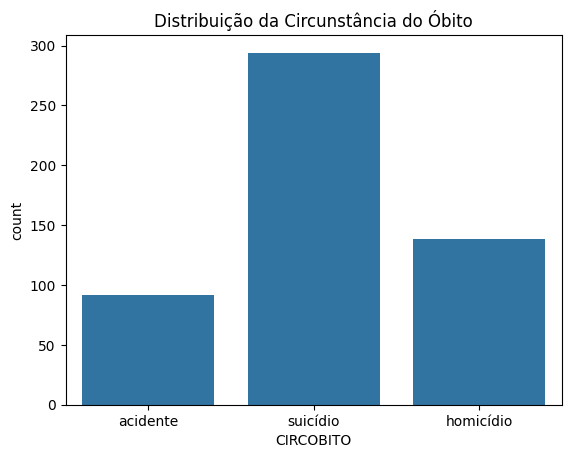

In [17]:
# Substitui valores '?' por valores nulos
df.replace('?', pd.NA, inplace=True)

# Remove linhas com dados faltantes
df.dropna(inplace=True)

# Remove registros com 'CIRCOBITO' igual a 'outros' ou 'ignorado'
df = df[(df["CIRCOBITO"] != "outros") & (df["CIRCOBITO"] != "ignorado")]

# Mostra informações do DataFrame
print(df.info())
df.isna().sum()

# Gráfico de distribuição da variável alvo "CIRCOBITO"
sns.countplot(x="CIRCOBITO", data=df)
plt.title("Distribuição da Circunstância do Óbito")
plt.show()

## Pré-processamento e Codificação

In [18]:
# Codifica todos os atributos categóricos em valores numéricos
encoders = {}
for col in df.columns:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

# Separa features (X) e variável alvo (y)
X = df.drop("CIRCOBITO", axis=1)
y = df["CIRCOBITO"]

## Classificação com Dados Originais (sem SMOTE)

In [24]:
# Divide os dados em treino e teste:
# - 70% para treinamento
# - 30% para teste
# Isso é importante para avaliar o desempenho do modelo em dados não vistos.
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# Cria uma instância do classificador Naive Bayes categórico
# Ideal para atributos codificados com valores discretos (ex: LabelEncoder)
model_orig = CategoricalNB()
# Treina o modelo usando os dados de treino (atributos e classes)
# Aqui o Naive Bayes aprende as distribuições de probabilidade de cada atributo por classe
model_orig.fit(X_train_orig, y_train_orig)
# Usa o modelo treinado para prever a classe das instâncias no conjunto de teste
# O resultado é um vetor com os rótulos previstos
y_pred_orig = model_orig.predict(X_test_orig)
# Avaliação 1: calcula a acurácia do modelo
# Acurácia = (número de previsões corretas) / (total de previsões)
print("Acurácia:", accuracy_score(y_test_orig, y_pred_orig))
# Avaliação 2: mostra a matriz de confusão
# Ela indica quantas vezes cada classe foi corretamente ou erroneamente prevista
# Linhas = classe verdadeira, Colunas = classe prevista
print("\nMatriz de Confusão:\n", confusion_matrix(y_test_orig, y_pred_orig))
# Avaliação 3: gera um relatório completo com as métricas:
# - precision: precisão (quantos dos classificados como X realmente são X)
# - recall: sensibilidade (quantos dos X reais foram classificados como X)
# - f1-score: média harmônica entre precisão e recall
# - support: número de exemplos reais de cada classe
print("\nRelatório de Classificação:\n", classification_report(y_test_orig, y_pred_orig))

Acurácia: 0.5316455696202531

Matriz de Confusão:
 [[ 7  5 17]
 [ 1 11 21]
 [ 8 22 66]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.44      0.24      0.31        29
           1       0.29      0.33      0.31        33
           2       0.63      0.69      0.66        96

    accuracy                           0.53       158
   macro avg       0.45      0.42      0.43       158
weighted avg       0.53      0.53      0.52       158



## Balanceamento com SMOTE

Distribuição após SMOTE:
 CIRCOBITO
0    294
2    294
1    294
Name: count, dtype: int64


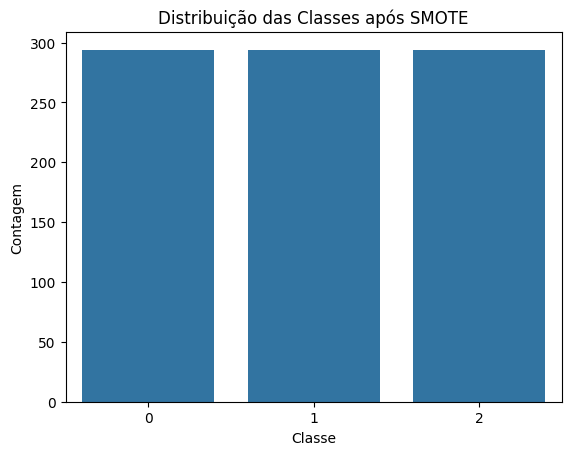

In [30]:
# Remove a classe 3 do conjunto de dados
# Motivo: ela possui poucos exemplos e pode causar erro no SMOTE
# (SMOTE precisa de pelo menos k+1 amostras da mesma classe)
X_bal = X[y != 3]
y_bal = y[y != 3]
# Instancia o SMOTE com k=2 (número de vizinhos mais próximos)
# SMOTE = Synthetic Minority Over-sampling Technique
# Ele vai gerar novos exemplos sintéticos para as classes minoritárias
smote = SMOTE(random_state=42, k_neighbors=2)
# Aplica o SMOTE nos dados balanceados (sem a classe 3)
# Gera novos exemplos sintéticos para igualar as quantidades entre as classes
X_resampled, y_resampled = smote.fit_resample(X_bal, y_bal)
# Mostra a nova distribuição de classes após o SMOTE
# Agora todas as classes devem ter o mesmo número de exemplos
print("Distribuição após SMOTE:\n", pd.Series(y_resampled).value_counts())
# Exibe graficamente a distribuição das classes balanceadas
# Gera um gráfico de barras para visualizar se o SMOTE funcionou
sns.countplot(x=y_resampled)
plt.title("Distribuição das Classes após SMOTE")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

## Classificação com Dados Balanceados (com SMOTE)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.539622641509434

Matriz de Confusão:
 [[50 13 16]
 [12 59 24]
 [25 32 34]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.57      0.63      0.60        79
           1       0.57      0.62      0.59        95
           2       0.46      0.37      0.41        91

    accuracy                           0.54       265
   macro avg       0.53      0.54      0.54       265
weighted avg       0.53      0.54      0.53       265



In [32]:
# Verifique os valores possíveis para cada atributo
print("IDADE:", encoders["IDADE"].classes_)
print("SEXO:", encoders["SEXO"].classes_)
print("RACACOR:", encoders["RACACOR"].classes_)
print("ESTCIV:", encoders["ESTCIV"].classes_)
print("ESC:", encoders["ESC"].classes_)

# Exemplo de entrada com valores existentes
entrada = pd.DataFrame([{
    "IDADE": encoders["IDADE"].transform(["idoso"])[0],
    "SEXO": encoders["SEXO"].transform(["masculino"])[0],
    "RACACOR": encoders["RACACOR"].transform(["branca"])[0],
    "ESTCIV": encoders["ESTCIV"].transform(["solteiro"])[0],
    "ESC": encoders["ESC"].transform(["4a7anos"])[0]
}])

# Predição
predicao = model.predict(entrada)[0]
classe_prevista = encoders["CIRCOBITO"].inverse_transform([predicao])[0]

print("Classe prevista (CIRCOBITO):", classe_prevista)


IDADE: ['adulto' 'idoso' 'jovem']
SEXO: ['feminino' 'masculino']
RACACOR: ['amarela' 'branca' 'parda' 'preta']
ESTCIV: ['casado' 'ignorado' 'separado' 'solteiro' 'viúvo']
ESC: ['12emais' '1a3anos' '4a7anos' '8a11anos' 'ignorado' 'nenhum']
Classe prevista (CIRCOBITO): acidente
